In [153]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import xlrd
from scipy.integrate import ode
from scipy import integrate
import xlsxwriter
from IPython.display import Image

In [173]:
comparision='table.png'
dt='data_table.png'
hand1='handcal-1.png'
hand2='handcal-2.png'
hand3='handcal-3.png'
hand4='handcal-4.png'


## Initial Condition

In [2]:
# All in units of metric

HPSI=0.02524
temp_HPSI=32.22
Break_Area=0.01824
Break_Height=18.90
Cross_Area=6.503
RCS_temp=304.4
RCS_pressure=9142448
Water_V=287.7
Steam_V=50.97
hi=137000
qdot=64e6 #Assume 2% of 3200 MW


workbook = xlrd.open_workbook("C:/Users/Zhonghan/Desktop/nuclear_power_plant/Therm_Pressure_Table.xlsx")
Thermo_data=np.zeros([73,6])
for i in np.arange(73):
    for j in np.arange(6):
        Thermo_data[i,j]=workbook.sheet_by_index(1).cell_value(i+1,j)
        if j == 0 or j == 3 or j == 4:
            Thermo_data[i,j]= Thermo_data[i,j]*1000

## Variables of P

In [86]:
def vf(p=None): #returns vf, and slope at a pressure
    if p in Thermo_data[:,0]:
        a=list(Thermo_data[:,0]).index(p)
        return ((Thermo_data[a,1]),(Thermo_data[a+1,1]-Thermo_data[a-1,1])/(Thermo_data[a+1,0]-Thermo_data[a-1,0]))
    else:
        a=list(Thermo_data[:,0] > p).index(1)
        return (((Thermo_data[a,1]-Thermo_data[a-1,1])/(Thermo_data[a,0]-Thermo_data[a-1,0]))*(p-Thermo_data[a-1,0])+Thermo_data[a-1,1],(Thermo_data[a,1]-Thermo_data[a-1,1])/(Thermo_data[a,0]-Thermo_data[a-1,0]))

def vg(p=None):
    if p in Thermo_data[:,0]:
        a=list(Thermo_data[:,0]).index(p)
        return (Thermo_data[a,2],(Thermo_data[a+1,2]-Thermo_data[a-1,2])/(Thermo_data[a+1,0]-Thermo_data[a-1,0]))
    else:
        a=list(Thermo_data[:,0] > p).index(1)
        return (((Thermo_data[a,2]-Thermo_data[a-1,2])/(Thermo_data[a,0]-Thermo_data[a-1,0]))*(p-Thermo_data[a-1,0])+Thermo_data[a-1,2],(Thermo_data[a,2]-Thermo_data[a-1,2])/(Thermo_data[a,0]-Thermo_data[a-1,0]))

def hf(p=None):
    if p in Thermo_data[:,0]:
        a=list(Thermo_data[:,0]).index(p)
        return (Thermo_data[a,3],(Thermo_data[a+1,3]-Thermo_data[a-1,3])/(Thermo_data[a+1,0]-Thermo_data[a-1,0]))
    else:
        a=list(Thermo_data[:,0] > p).index(1)
        return (((Thermo_data[a,3]-Thermo_data[a-1,3])/(Thermo_data[a,0]-Thermo_data[a-1,0]))*(p-Thermo_data[a-1,0])+Thermo_data[a-1,3],(Thermo_data[a,3]-Thermo_data[a-1,3])/(Thermo_data[a,0]-Thermo_data[a-1,0]))

def hg(p=None):
    if p in Thermo_data[:,0]:
        a=list(Thermo_data[:,0]).index(p)
        return (Thermo_data[a,4],(Thermo_data[a+1,4]-Thermo_data[a-1,4])/(Thermo_data[a+1,0]-Thermo_data[a-1,0]))
    else:
        a=list(Thermo_data[:,0] > p).index(1)
        return (((Thermo_data[a,4]-Thermo_data[a-1,4])/(Thermo_data[a,0]-Thermo_data[a-1,0]))*(p-Thermo_data[a-1,0])+Thermo_data[a-1,4],(Thermo_data[a,4]-Thermo_data[a-1,4])/(Thermo_data[a,0]-Thermo_data[a-1,0]))
def mout_f(p=None):
    return(Break_Area*8300.54*(p/1378952)**0.71)
def mout_g(p=None):
    return(Break_Area*1953.0678*(p/1378952)**1.02)

Some unit conversion

$$\dot{m}_{out.f}=1700 \frac{lb}{s \cdot ft^2} \times \left(\frac{P}{200 psia}\right)^{0.71}= 1700 \frac{lb}{s \cdot ft^2} \left(\frac{0.4536 kg}{1lb}\right)\left(\frac{1 ft^2}{0.0929 m^2}\right) \times \left(\frac{P}{200 psia}\frac{1psia}{6894.76 pa}\right)^{0.71}$$ 
$$=8300.54 \frac{kg}{s \cdot m^2} \times \left(\frac{P}{1,378,952 pascal}\right)^{0.71}$$

In [87]:
def system_eq1( t=None,y=None):
    vfg=vg(y[0])[0]-vf(y[0])[0]
    hfg=hg(y[0])[0]-hf(y[0])[0]
    a=vfg*((hi*HPSI/vf(y[0])[0]-hf(y[0])[0]*mout_f(y[0]))+qdot)
    b=(HPSI/vf(y[0])[0]-mout_f(y[0]))*(vg(y[0])[0]*hfg-hg(y[0])[0]*vfg)
    c=vfg*(y[1]*hf(y[0])[1]+y[2]*hg(y[0])[1]-(y[1]*vf(y[0])[0]+y[2]*vg(y[0])[0]))
    d=hfg*(y[1]*vf(y[0])[1]+y[2]*vg(y[0])[1])
    return (np.array([(a+b)/(c-d),HPSI/vf(y[0])[0]-mout_f(y[0])-(qdot/(hf(y[0])[0]-hi)),qdot/(hf(y[0])[0]-hi)]))

def system_eq2( t=None, y=None):
    vfg=vg(y[0])[0]-vf(y[0])[0]
    hfg=hg(y[0])[0]-hf(y[0])[0]
    a=vfg*((hi*HPSI/vf(y[0])[0]-hg(y[0])[0]*mout_g(y[0]))+qdot)
    b=(HPSI/vf(y[0])[0]-mout_g(y[0]))*(vg(y[0])[0]*hfg-hg(y[0])[0]*vfg)
    c=vfg*(y[1]*hf(y[0])[1]+y[2]*hg(y[0])[1]-(y[1]*vf(y[0])[0]+y[2]*vg(y[0])[0]))
    d=hfg*(y[1]*vf(y[0])[1]+y[2]*vg(y[0])[1])
    return (np.array([(a+b)/(c-d),HPSI/vf(y[0])[0]-(qdot/(hg(y[0])[0]-hi)),qdot/(hg(y[0])[0]-hi)-mout_g(y[0])]))

y0=np.array([RCS_pressure, Water_V/(vf(RCS_pressure)[0]), Steam_V/(vg(RCS_pressure)[0])])

## Runge Kutta Integrator Method

In [148]:
Solver = ode(system_eq1).set_integrator("dopri5")
Solver.set_initial_value(y0,0)
t=0.1
i=1
val=Solver.integrate(t)

DATA1=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)]) # time, pressure, fluid mass, steam mass, water level, flow out
DATA1=np.vstack([DATA1,np.append(np.append(t,val),[(val[1]*vf(val[0])[0])/Cross_Area,mout_f(val[0])])])

while DATA1[i,4] >  Break_Height: #62 ft
    t += 0.1
    i += 1
    val=Solver.integrate(t)
    DATA1=np.vstack([DATA1,np.append(np.append(t,val),[(val[1]*vf(val[0])[0])/Cross_Area,mout_f(val[0])])])


In [149]:
t_crit=t
i_crit=i

Solver2=ode(system_eq2).set_integrator("dopri5")
Solver2.set_initial_value(DATA1[i][1:4],t)
while DATA1[i,4] >  17.31: #56.79 ft
    t += 0.1
    i += 1
    val=Solver2.integrate(t)
    DATA1=np.vstack([DATA1,np.append(np.append(t,val),[(val[1]*vf(val[0])[0])/Cross_Area,mout_f(val[0])])])
    

In [91]:
DATA1

array([[  0.00000000e+00,   9.14244800e+06,   2.02200772e+05,
          2.53098112e+03,   4.42411195e+01,   5.79970173e+02],
       [  1.00000000e-01,   9.14225418e+06,   2.02139359e+05,
          2.53617181e+03,   4.42274775e+01,   5.79961443e+02],
       [  2.00000000e-01,   9.14206034e+06,   2.02077946e+05,
          2.54136253e+03,   4.42138359e+01,   5.79952713e+02],
       ..., 
       [  2.64100000e+02,   5.37872629e+06,   8.67039668e+04,
          4.44394596e+02,   1.73127671e+01,   3.97954748e+02],
       [  2.64200000e+02,   5.37486366e+06,   8.67034989e+04,
          4.32532750e+02,   1.73109742e+01,   3.97751820e+02],
       [  2.64300000e+02,   5.37100141e+06,   8.67030312e+04,
          4.20681328e+02,   1.73091815e+01,   3.97548871e+02]])

## Euler Method

### Time Step = 10 sec

In [92]:
def Euler_Method(Table=None, dt=None):
    j=1

    Table=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)]) # time, pressure, fluid mass, steam mass, water level, flow out
    val2 = Table[1:4]+system_eq1(0,Table[1:4])*dt
    layer= np.append(np.append(j*dt,val2),[(val2[1]*vf(val2[0])[0])/Cross_Area,mout_f(val2[0])])
    Table=np.vstack([Table,layer])

    while Table[j,4] >  Break_Height: #62 ft
        j += 1
        val2 = Table[j-1][1:4]+system_eq1(0,Table[j-1][1:4])*dt
        layer= np.append(np.append(j*dt,val2),[(val2[1]*vf(val2[0])[0])/Cross_Area,mout_f(val2[0])])
        Table=np.vstack([Table,layer])

    j_crit=j

    while Table[j,4] >   17.31: #56.79 ft
        j += 1
        val2 = Table[j-1][1:4]+system_eq2(0,Table[j-1][1:4])*dt
        layer= np.append(np.append(j*dt,val2),[(val2[1]*vf(val2[0])[0])/Cross_Area,mout_f(val2[0])])
        Table=np.vstack([Table,layer])
    return(j_crit*dt, Table)

In [93]:
DATA2=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)])
DATA2=Euler_Method(DATA2,10)
print(DATA2)

(190, array([[  0.00000000e+00,   9.14244800e+06,   2.02200772e+05,
          2.53098112e+03,   4.42411195e+01,   5.79970173e+02],
       [  1.00000000e+01,   9.12306648e+06,   1.96059395e+05,
          3.05004792e+03,   4.28775312e+01,   5.79096955e+02],
       [  2.00000000e+01,   9.10355126e+06,   1.89926472e+05,
          3.56947480e+03,   4.15169029e+01,   5.78217169e+02],
       [  3.00000000e+01,   9.08389729e+06,   1.83802067e+05,
          4.08926474e+03,   4.01592538e+01,   5.77330575e+02],
       [  4.00000000e+01,   9.06409926e+06,   1.77686245e+05,
          4.60942084e+03,   3.88046040e+01,   5.76436919e+02],
       [  5.00000000e+01,   9.04415155e+06,   1.71579074e+05,
          5.12994631e+03,   3.74529745e+01,   5.75535935e+02],
       [  6.00000000e+01,   9.02404824e+06,   1.65480625e+05,
          5.65084447e+03,   3.61043873e+01,   5.74627339e+02],
       [  7.00000000e+01,   9.00378306e+06,   1.59390972e+05,
          6.17211876e+03,   3.47588652e+01,   5.73710833e

### Time Step = 1 sec

In [94]:
DATA3=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)])
DATA3=Euler_Method(DATA3,1)
print(DATA3)

(190, array([[  0.00000000e+00,   9.14244800e+06,   2.02200772e+05,
          2.53098112e+03,   4.42411195e+01,   5.79970173e+02],
       [  1.00000000e+00,   9.14050985e+06,   2.01586634e+05,
          2.58288780e+03,   4.41047046e+01,   5.79882875e+02],
       [  2.00000000e+00,   9.13857039e+06,   2.00972581e+05,
          2.63479808e+03,   4.39683194e+01,   5.79795514e+02],
       ..., 
       [  2.62000000e+02,   5.45636381e+06,   8.66454924e+04,
          6.76342459e+02,   1.73352276e+01,   4.02024613e+02],
       [  2.63000000e+02,   5.41762816e+06,   8.66407666e+04,
          5.55576073e+02,   1.73172513e+01,   3.99996151e+02],
       [  2.64000000e+02,   5.37891818e+06,   8.66360634e+04,
          4.35855413e+02,   1.72992928e+01,   3.97964828e+02]]))


### Time Step = 0.1sec

In [95]:
DATA4=np.append(np.append(0,y0),[Water_V/Cross_Area,mout_f(RCS_pressure)])
DATA4=Euler_Method(DATA4,0.1)
print(DATA4)

(189.9, array([[  0.00000000e+00,   9.14244800e+06,   2.02200772e+05,
          2.53098112e+03,   4.42411195e+01,   5.79970173e+02],
       [  1.00000000e-01,   9.14225418e+06,   2.02139358e+05,
          2.53617179e+03,   4.42274774e+01,   5.79961444e+02],
       [  2.00000000e-01,   9.14206036e+06,   2.02077945e+05,
          2.54136249e+03,   4.42138357e+01,   5.79952713e+02],
       ..., 
       [  2.64100000e+02,   5.37790457e+06,   8.67031055e+04,
          4.40725010e+02,   1.73122336e+01,   3.97911582e+02],
       [  2.64200000e+02,   5.37404156e+06,   8.67026374e+04,
          4.28860168e+02,   1.73104405e+01,   3.97708625e+02],
       [  2.64300000e+02,   5.37017893e+06,   8.67021697e+04,
          4.17005753e+02,   1.73086476e+01,   3.97505646e+02]]))


## Results

<IPython.core.display.Javascript object>


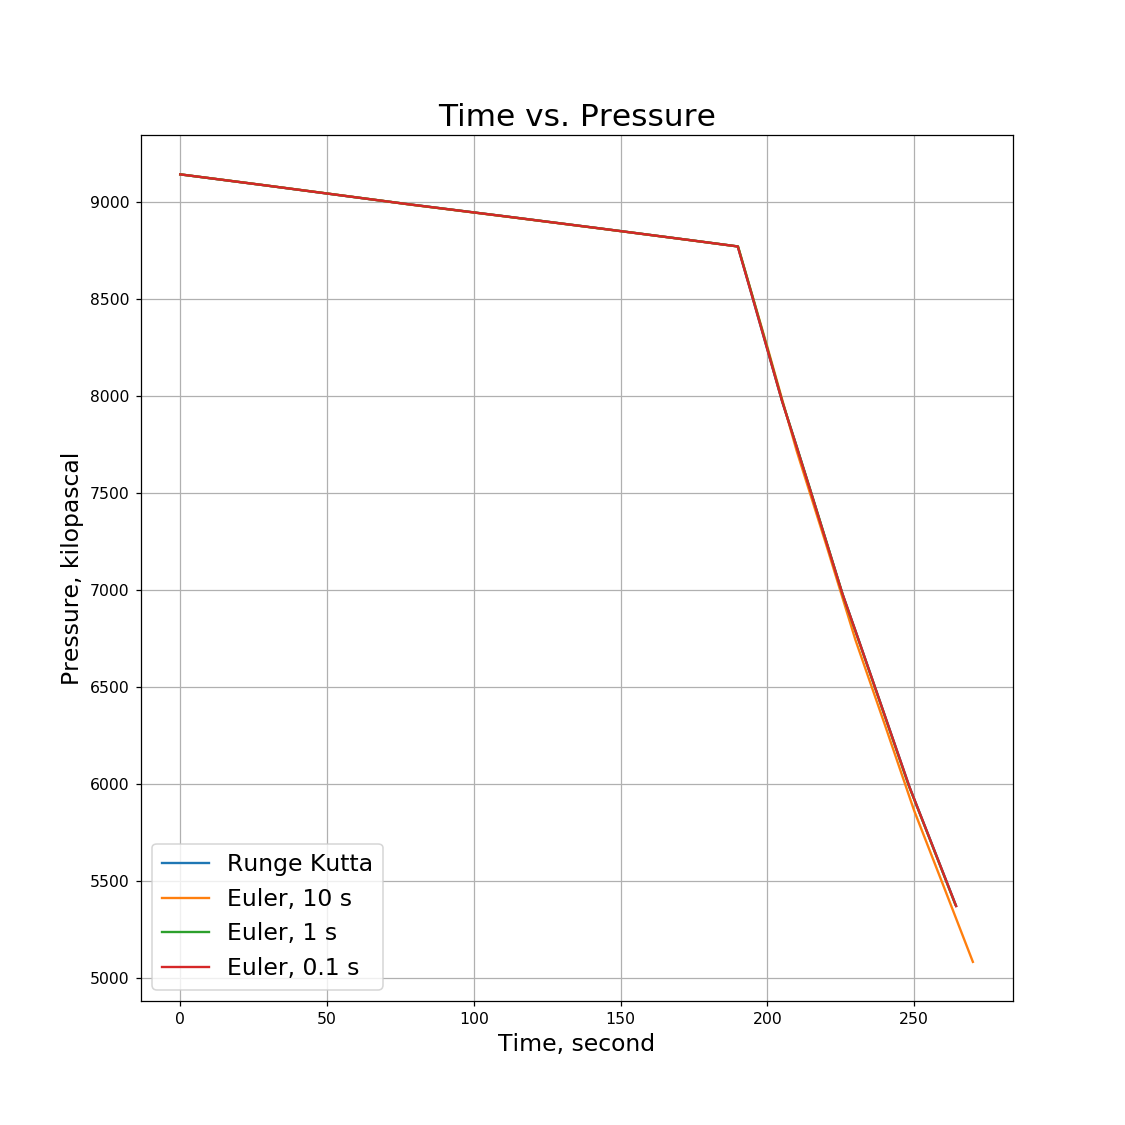

In [135]:
plt.figure(figsize=(10,10))    
plt.title(r"Time vs. Pressure", fontsize=20)
plt.xlabel(r"Time, second", fontsize=15)
plt.ylabel(r"Pressure, kilopascal", fontsize=15)
plt.plot(DATA1[:,0], DATA1[:,1]/1000, label="Runge Kutta")
plt.plot(DATA2[1][:,0], DATA2[1][:,1]/1000, label="Euler, 10 s")
plt.plot(DATA3[1][:,0], DATA3[1][:,1]/1000, label="Euler, 1 s")
plt.plot(DATA4[1][:,0], DATA4[1][:,1]/1000, label="Euler, 0.1 s")
plt.grid("True")
plt.legend(loc=3,fontsize=15)
plt.show()

<IPython.core.display.Javascript object>


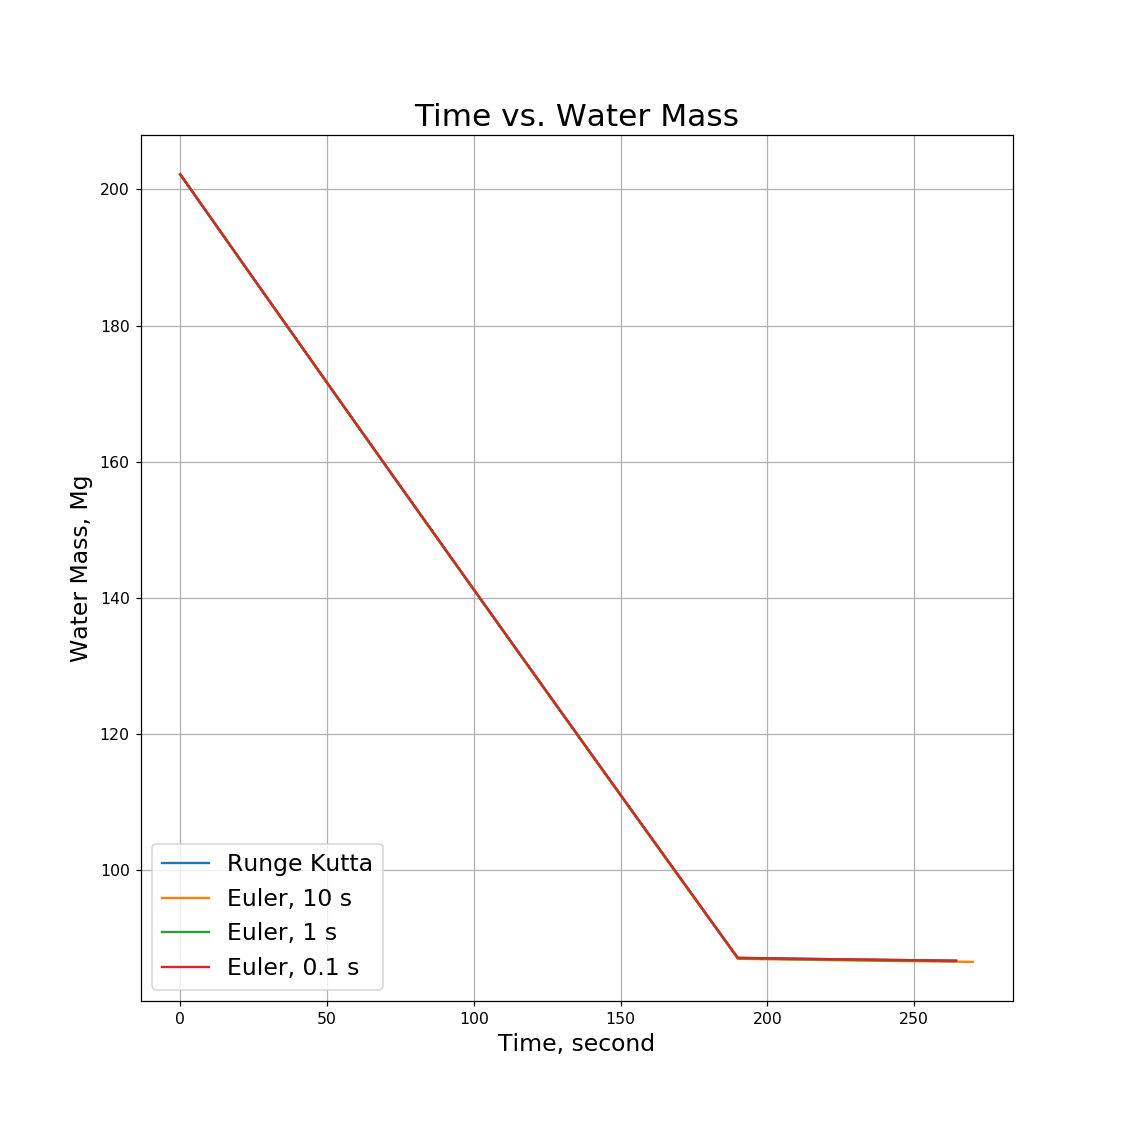

In [98]:
plt.figure(figsize=(10,10))    
plt.title(r"Time vs. Water Mass", fontsize=20)
plt.xlabel(r"Time, second", fontsize=15)
plt.ylabel(r"Water Mass, Mg", fontsize=15)
plt.plot(DATA1[:,0], DATA1[:,2]/1000, label="Runge Kutta")
plt.plot(DATA2[1][:,0], DATA2[1][:,2]/1000, label="Euler, 10 s")
plt.plot(DATA3[1][:,0], DATA3[1][:,2]/1000, label="Euler, 1 s")
plt.plot(DATA4[1][:,0], DATA4[1][:,2]/1000, label="Euler, 0.1 s")
plt.grid("True")
plt.legend(loc=3,fontsize=15)
plt.show()

<IPython.core.display.Javascript object>


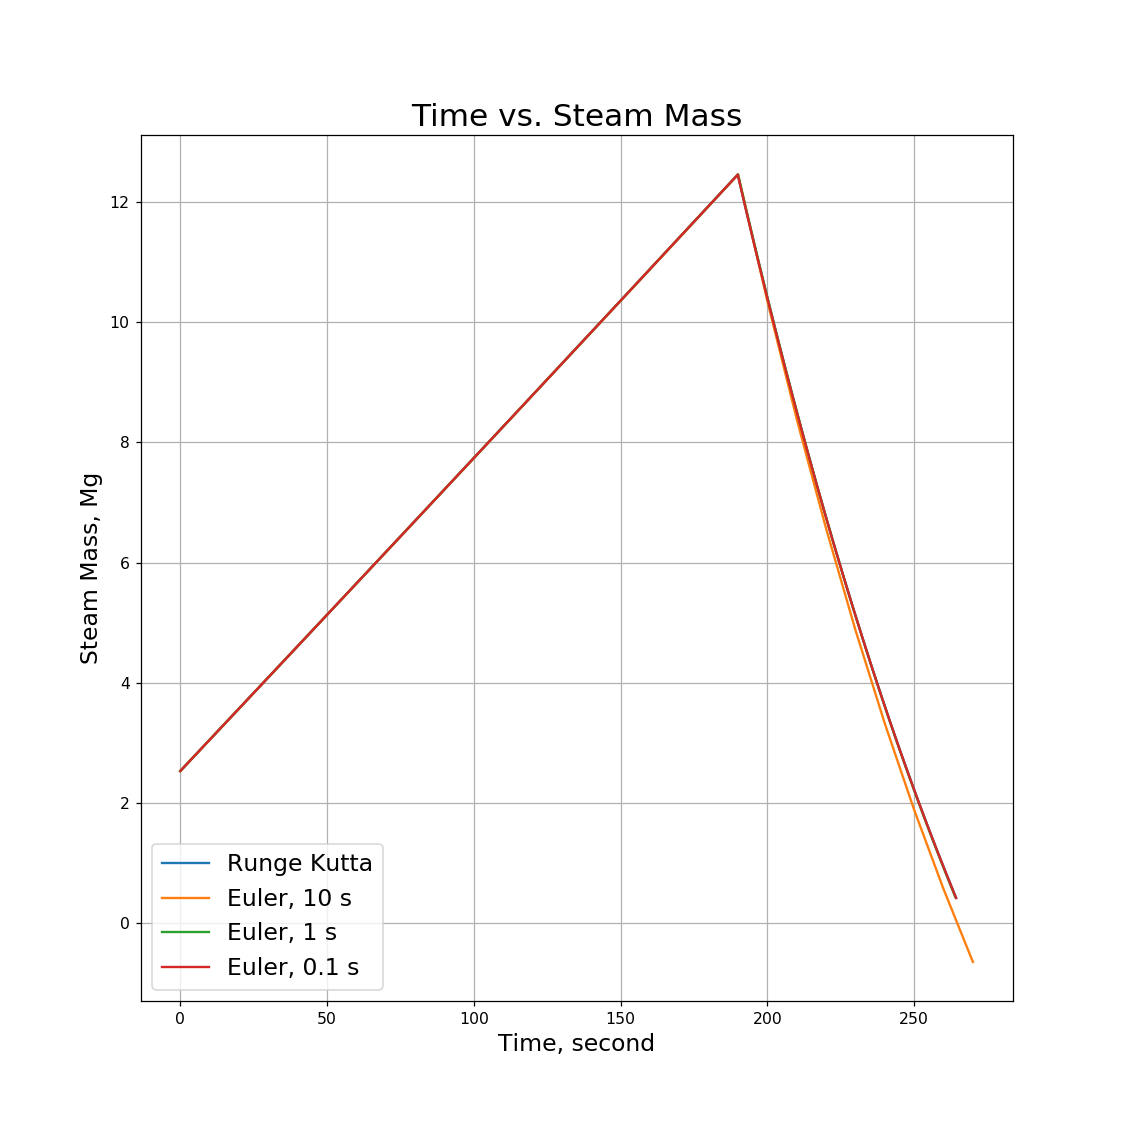

In [102]:
plt.figure(figsize=(10,10))    
plt.title(r"Time vs. Steam Mass", fontsize=20)
plt.xlabel(r"Time, second", fontsize=15)
plt.ylabel(r"Steam Mass, Mg", fontsize=15)
plt.plot(DATA1[:,0], DATA1[:,3]/1000, label="Runge Kutta")
plt.plot(DATA2[1][:,0], DATA2[1][:,3]/1000, label="Euler, 10 s")
plt.plot(DATA3[1][:,0], DATA3[1][:,3]/1000, label="Euler, 1 s")
plt.plot(DATA4[1][:,0], DATA4[1][:,3]/1000, label="Euler, 0.1 s")
plt.grid("True")
plt.legend(loc=3,fontsize=15)
plt.show()

<IPython.core.display.Javascript object>


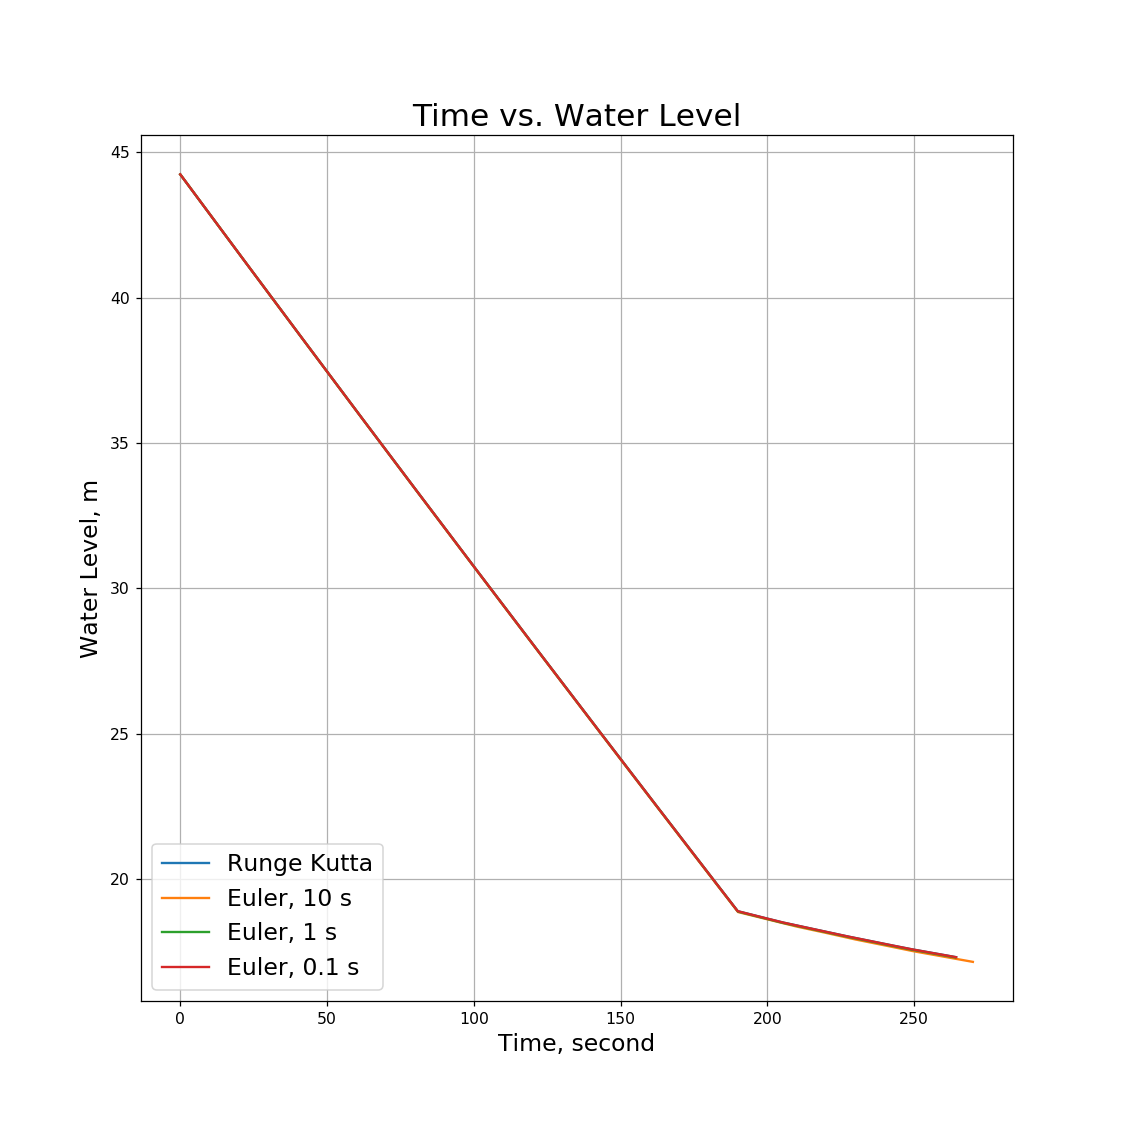

In [103]:
plt.figure(figsize=(10,10))    
plt.title(r"Time vs. Water Level", fontsize=20)
plt.xlabel(r"Time, second", fontsize=15)
plt.ylabel(r"Water Level, m", fontsize=15)
plt.plot(DATA1[:,0], DATA1[:,4], label="Runge Kutta")
plt.plot(DATA2[1][:,0], DATA2[1][:,4], label="Euler, 10 s")
plt.plot(DATA3[1][:,0], DATA3[1][:,4], label="Euler, 1 s")
plt.plot(DATA4[1][:,0], DATA4[1][:,4], label="Euler, 0.1 s")
plt.grid("True")
plt.legend(loc=3,fontsize=15)
plt.show()

<IPython.core.display.Javascript object>


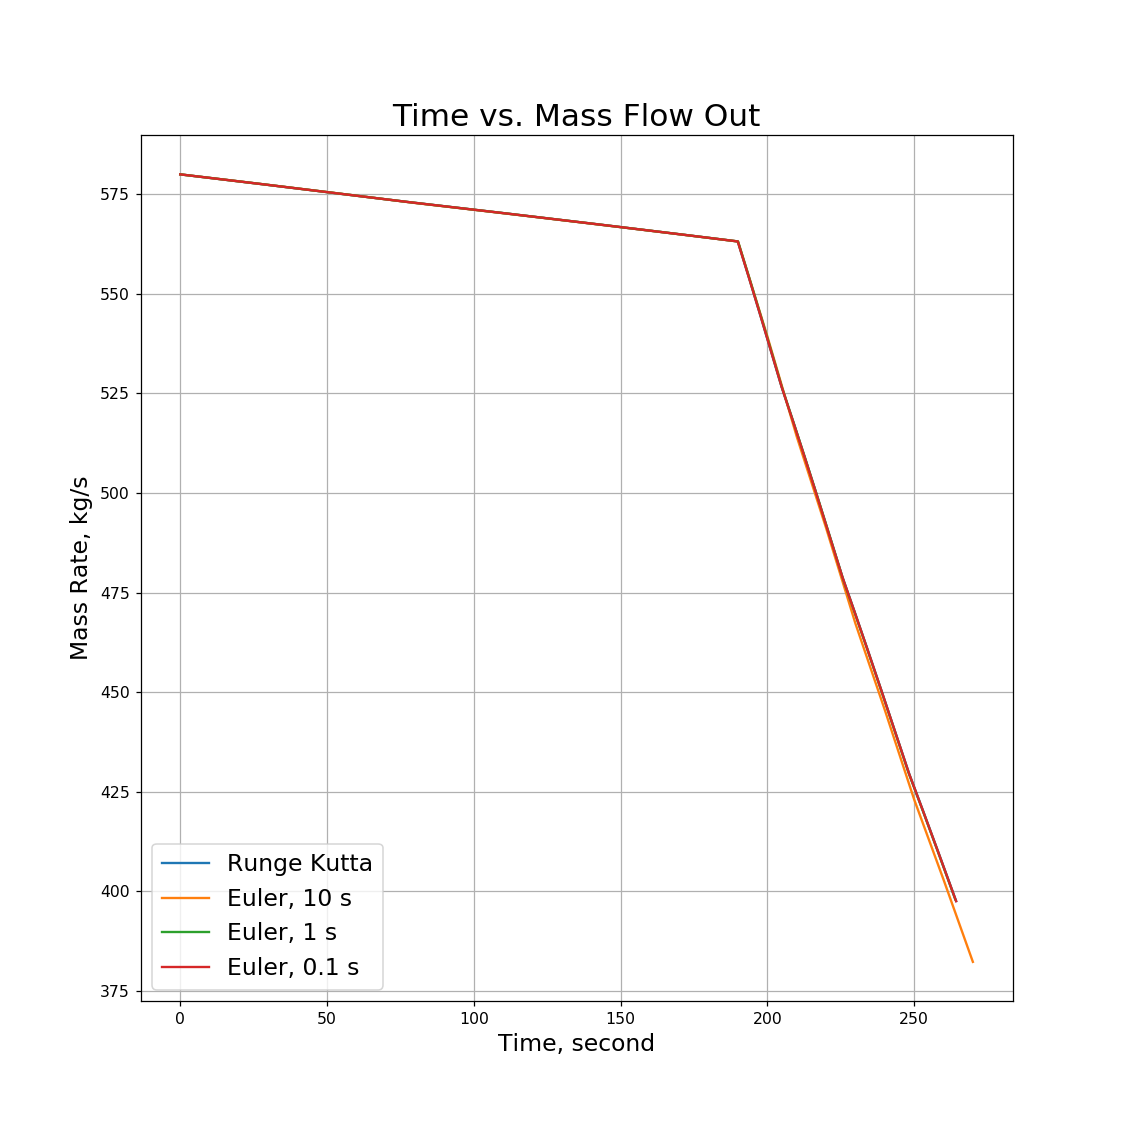

In [142]:
plt.figure(figsize=(10,10))    
plt.title(r"Time vs. Mass Flow Out", fontsize=20)
plt.xlabel(r"Time, second", fontsize=15)
plt.ylabel(r"Mass Rate, kg/s", fontsize=15)
plt.plot(DATA1[:,0], DATA1[:,5], label="Runge Kutta")
plt.plot(DATA2[1][:,0], DATA2[1][:,5], label="Euler, 10 s")
plt.plot(DATA3[1][:,0], DATA3[1][:,5], label="Euler, 1 s")
plt.plot(DATA4[1][:,0], DATA4[1][:,5], label="Euler, 0.1 s")
plt.grid("True")
plt.legend(loc=3,fontsize=15)
plt.show()

In [152]:
book = xlsxwriter.Workbook("Testing.xlsx")
sheet1=book.add_worksheet('Pressure')
sheet2=book.add_worksheet('Water Mass')
sheet3=book.add_worksheet('Steam Mass')
sheet4=book.add_worksheet('Water Level')
sheet5=book.add_worksheet('Mass Flow')


def writedata(array=None, sheet=None,col=None):
    for i in np.arange(len(array)):
        sheet.write(i+1,col+1,array[i])

writedata(DATA1[:,0][::100],sheet1,0)
writedata(DATA1[:,1][::100]/1000,sheet1,1)
writedata(DATA2[1][:,1]/1000,sheet1,2)
writedata(DATA3[1][:,1][::10]/1000,sheet1,3)
writedata(DATA4[1][:,1][::100]/1000,sheet1,4)

writedata(DATA1[:,0],sheet2,6)
writedata(DATA1[:,1]/1000,sheet2,7)
writedata(DATA1[:,2]/1000,sheet2,8)
writedata(DATA1[:,3]/1000,sheet2,9)
writedata(DATA1[:,4],sheet2,10)
writedata(DATA1[:,5],sheet2,11)

book.close()

In [144]:
system_eq1(0,y0)

array([-1938.15185994,  -614.13772396,    51.9066801 ])

In [79]:
qdot/(hf(y0[0])[0]-hi)

51.906680099440685

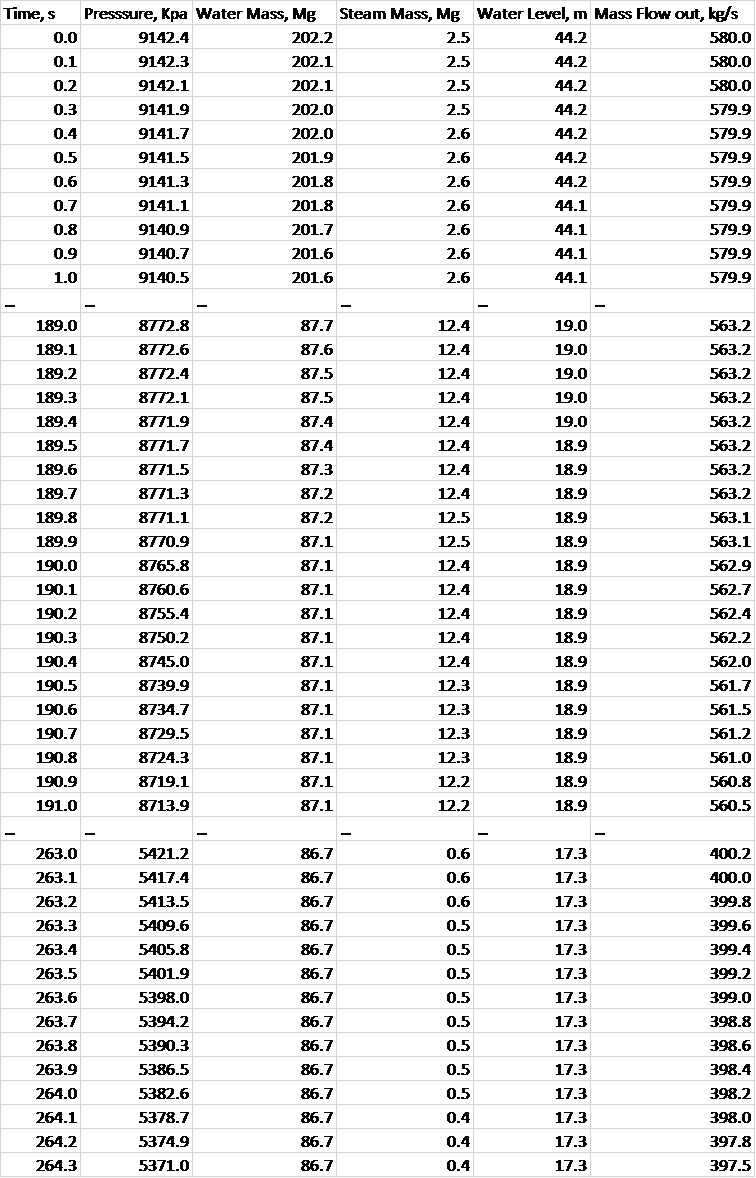

In [171]:
Image(Dt)